# Unstructured Data Analytics HW2

Name: Zhihan Li

Andrew ID: zhihanli

Collaborators (if none, say "none"; do *not* leave this blank): none

Reminder: you should not be sharing code.

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). We have already curated the data for you in the `data/enron` directory, with one file per email (so there is no need to redownload the dataset as it is already included in this homework zip archive). The dataset includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam.

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the `make_word_list` function, construct a list of processed documents.

In [1]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [2]:
########################################################################
######################### Write your code here #########################
########################################################################
import glob
processed_docs = []
for path in glob.glob('./data/enron/*.txt'):
    processed_docs.append(make_word_list(path))

### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [3]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=50, stop_words="english", max_df=0.8)
X = tfidf.fit_transform(processed_docs)
print(len(tfidf.vocabulary_))

1680


### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix `X` using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [4]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(X.toarray())
cluster_assignments = gmm.predict(X.toarray())
for i in range(3):
    cluster_size = sum([1 * (c == i) for c in cluster_assignments])
    print("cluster", i, ":", cluster_size)

cluster 0 : 2334
cluster 1 : 915
cluster 2 : 1922


### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes the following parameters:
    - `X` is a matrix of TF-IDF features (rows index documents, columns index terms).
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [5]:
def plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

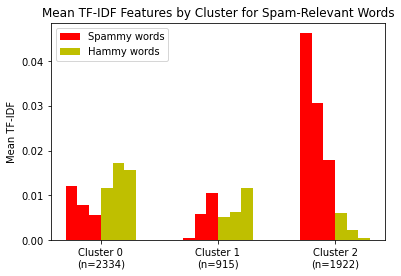

In [6]:
########################################################################
######################### Write your code here #########################
########################################################################
spam_indices = [tfidf.vocabulary_['click'], tfidf.vocabulary_['www'], tfidf.vocabulary_['offer']]
ham_indices = [tfidf.vocabulary_['meeting'], tfidf.vocabulary_['attached'], tfidf.vocabulary_['review']]
plot_spam_words_by_cluster(X, cluster_assignments, 3, spam_indices, ham_indices)

### Part E: Interpret results [10 points]

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

*** WRITE YOUR ANSWER HERE IN TEXT ***
In part (d), the third cluster should correspond to spam emails due to its high frequency for spammy words and much lower frequency for hammy words. The first cluster might be business emails with hammy words generally having higher frequency than spammy words. \
By changing the number of clusters, for instance to 5, we can see there cluster 2, 3, and 4 should all correspond to spam emails and cluster 0 and 1 should correspond to business emails. They can actually be merged together. n_clusters = 2 gives a better result as it merge spam clusters and ham clusters respectively, leading to two merged clusters.

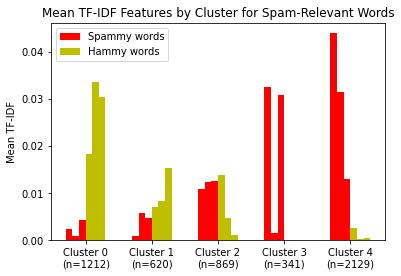

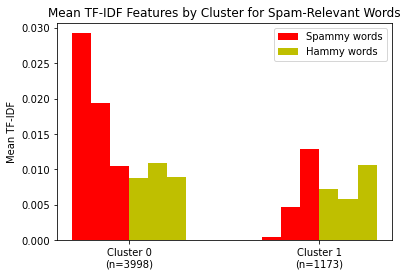

In [7]:
########################################################################
######################### Write your code here #########################
########################################################################
gmm_5 = GaussianMixture(n_components=5, random_state=0)
gmm_5.fit(X.toarray())
cluster_assignments_5 = gmm_5.predict(X.toarray())
plot_spam_words_by_cluster(X, cluster_assignments_5, 5, spam_indices, ham_indices)

gmm_2 = GaussianMixture(n_components=2, random_state=0)
gmm_2.fit(X.toarray())
cluster_assignments_2 = gmm_2.predict(X.toarray())
plot_spam_words_by_cluster(X, cluster_assignments_2, 2, spam_indices, ham_indices)

## Question 2: Latent "Purposes" in Mobile Apps [45 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [9]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [10]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [11]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [12]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.values
del df # uncomment to free up RAM
del df_perms # uncomment to free up RAM

### Part C: Downweight "stopwords" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [13]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = TfidfTransformer()
X_trans = vectorizer.fit_transform(X)

### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [14]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0, n_jobs=-1, max_iter=10)
lda.fit(X_trans)

CPU times: user 8.65 s, sys: 762 ms, total: 9.41 s
Wall time: 2min 40s


LatentDirichletAllocation(n_jobs=-1, random_state=0)

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

In [15]:
########################################################################
######################### Write your code here #########################
########################################################################
num_top_words = 10
topic_word_dist = np.array([row / row.sum() for row in lda.components_])
for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(-topic_word_dist[topic_idx])
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(permission_columns[word_idx], ":", topic_word_dist[topic_idx, word_idx])
    print()

[Topic 0]
Your location : coarse (network-based) location (D) : 0.25263653565583427
Your location : fine (GPS) location (D) : 0.24252720873391073
Network communication : full Internet access (D) : 0.15199326092068594
Network communication : view network state (S) : 0.10141803527778044
Phone calls : read phone state and identity (D) : 0.08185838560381938
Storage : modify/delete USB storage contents modify/delete SD card contents (D) : 0.06379643094513857
Services that cost you money : directly call phone numbers (D) : 0.051092697118316786
Network communication : view Wi-Fi state (S) : 0.026962007867490183
Your personal information : read sensitive log data (D) : 0.02158493529798257
Hardware controls : test hardware (S) : 0.0021507584583803823

[Topic 1]
Hardware controls : control vibrator (S) : 0.43315286583604024
Network communication : full Internet access (D) : 0.14102352919735206
Network communication : view network state (S) : 0.09436993211549445
Storage : modify/delete USB storag

*** WRITE YOUR ANSWER HERE IN TEXT ***
Topic 2: applicatoins that has payment functionalities.
Topic 5: maybe chat applications


### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [16]:
########################################################################
######################### Write your code here #########################
########################################################################
num_top_apps = 3
doc_topic_matrix = lda.transform(X_trans)
filtered_apps = [app for app, num in zip(app_names, app_ratings) if num >= 100000]
filtered_doc_topic = np.array([dist for dist, num in zip(doc_topic_matrix, app_ratings) if num >= 100000])
for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    topic_doc_array = np.array([filtered_doc_topic[i, topic_idx] for i in range(len(filtered_doc_topic))])
    sort_indices = np.argsort(-topic_doc_array)
    for rank in range(num_top_apps):
        word_idx = sort_indices[rank]
        print(filtered_apps[word_idx], ":", topic_doc_array[word_idx])
    print()

[Topic 0]
Dictionary.com : 0.7169209884462354
Air Control Lite : 0.7169209884462354
Paper Toss : 0.6935381403208715

[Topic 1]
Live Holdem Poker Pro : 0.7166983183679115
Vaulty Free Hides Pictures : 0.7166983183679115
Bubble Blast 2 : 0.6932401124059416

[Topic 2]
Angry Birds Seasons : 0.6247330077338598
Yoo Ninja! Free : 0.6247330077338598
Adobe Reader : 0.549969102236762

[Topic 3]
Lookout Security & Antivirus : 0.8569163447537493
Antivirus Free : 0.8544503907474101
WhatsApp Messenger : 0.8455299046384344

[Topic 4]
Real BlackJack : 0.7163520872799772
Alchemy : 0.7154622330070897
Tank Hero : 0.7153334203786537

[Topic 5]
World Newspapers : 0.6962019779666523
Paradise Island : 0.6962019779666523
My Country : 0.6962019779666523

[Topic 6]
Brightest Flashlight Free™ : 0.7624657178487542
Brightest Flashlight Free??? : 0.7624657178487542
Tiny Flashlight + LED : 0.749671949061801

[Topic 7]
Slice It! : 0.7208911879160542
Racing Moto : 0.6877727024108419
ES File Explorer : 0.673468430240249

### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [10 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

/Users/zhihanli/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/zhihanli/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CPU times: user 48 s, sys: 1.01 s, total: 49 s
Wall time: 13.8 s


(-81.75561180114747, 117.56828727722169, -113.6191177368164, 79.56200408935547)

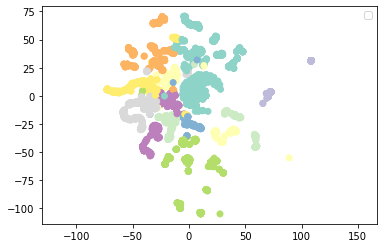

In [34]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.manifold import TSNE

#random sampling
np.random.seed(0)
sample = np.random.permutation(doc_topic_matrix.shape[0])[:5000]

tsne = TSNE(n_components=2, random_state=0, angle=0.99, init='pca')
doc_topic_2d = tsne.fit_transform(doc_topic_matrix[sample])

most_prob_color = [np.argsort(-doc_topic_matrix[sample][i])[0] for i in range(len(sample))]
plt.scatter(doc_topic_2d[:, 0], doc_topic_2d[:, 1], c=most_prob_color, cmap='Set3')
plt.legend()
plt.axis('equal')

## Question 3: Questionnaire [5 points]

Please answer this survey after you have done this homework: https://forms.gle/vXbmEehDByuxtgCG9